In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Understanding the Data

In [2]:
# Load 'Wildfire' dataset
df = pd.read_csv('all_conditions.csv')

In [3]:
df

,Stn Id,Stn Name,CIMIS Region,Date,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),Target
0,2,FivePoints,San Joaquin Valley,1/1/2018,0.06,0.00,219.0,7.3,63.4,35.3,47.8,82.0,46.0,65.0,36.6,3.3,78.3,51.1,0
1,2,FivePoints,San Joaquin Valley,1/2/2018,0.04,0.00,127.0,7.4,59.8,37.7,47.2,80.0,52.0,67.0,36.7,3.1,74.5,51.3,0
2,2,FivePoints,San Joaquin Valley,1/3/2018,0.04,0.00,125.0,8.4,61.1,37.3,49.9,79.0,49.0,68.0,39.9,4.5,107.5,51.3,0
3,2,FivePoints,San Joaquin Valley,1/4/2018,0.07,0.01,219.0,11.6,69.2,48.7,56.8,94.0,52.0,74.0,48.5,5.8,140.2,53.0,0
4,2,FivePoints,San Joaquin Valley,1/5/2018,0.07,0.00,239.0,12.7,73.8,47.5,59.8,94.0,49.0,72.0,50.8,4.2,101.4,54.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128120,262,Linden,San Joaquin Valley,9/14/2020,0.14,0.00,420.0,15.4,84.3,53.7,66.3,95.0,39.0,70.0,56.2,3.4,81.7,69.4,1
128121,262,Linden,San Joaquin Valley,9/15/2020,0.15,0.00,430.0,15.1,86.8,49.6,66.0,96.0,31.0,69.0,55.7,2.7,64.2,69.0,1
128122,262,Linden,San Joaquin Valley,9/16/2020,0.15,0.00,445.0,16.2,89.0,53.6,68.0,97.0,30.0,69.0,57.6,3.3,78.2,69.0,1
128123,262,Linden,San Joaquin Valley,9/17/2020,0.16,0.00,447.0,16.6,88.1,53.3,70.4,97.0,35.0,65.0,58.3,3.3,78.1,69.5,1


## Data Cleaning

### Dropping Unnecessary Columns

In [4]:
# Dropping the columns with 'min' and 'max' in their names, as well as non-numerical columns

# Columns to drop
columns_to_drop = [col for col in df.columns if ('min' in col.lower() or 'max' in col.lower() or df[col].dtype == 'object')]

# Dropping the columns
df = df.drop(columns=columns_to_drop)

# Displaying the columns of the cleaned data
cleaned_columns = df.columns
cleaned_columns, df.head()

(Index(['Stn Id', 'ETo (in)', 'Precip (in)', 'Sol Rad (Ly/day)',
        'Avg Vap Pres (mBars)', 'Avg Air Temp (F)', 'Avg Rel Hum (%)',
        'Dew Point (F)', 'Avg Wind Speed (mph)', 'Wind Run (miles)',
        'Avg Soil Temp (F)', 'Target'],
       dtype='object'),
    Stn Id  ETo (in)  Precip (in)  Sol Rad (Ly/day)  Avg Vap Pres (mBars)  \
 0       2      0.06         0.00             219.0                   7.3   
 1       2      0.04         0.00             127.0                   7.4   
 2       2      0.04         0.00             125.0                   8.4   
 3       2      0.07         0.01             219.0                  11.6   
 4       2      0.07         0.00             239.0                  12.7   
 
    Avg Air Temp (F)  Avg Rel Hum (%)  Dew Point (F)  Avg Wind Speed (mph)  \
 0              47.8             65.0           36.6                   3.3   
 1              47.2             67.0           36.7                   3.1   
 2              49.9             

### Handling Missing Values

In [5]:
# Imputing missing values by the mean for the DataFrame 'df'
df = df.copy()  # Assuming 'data_cleaned' as the current state of the DataFrame

# Imputing missing values with the mean for each column
df = df.fillna(df.mean())

# Verifying if there are any missing values left
missing_values_after_imputation = df.isnull().sum()
missing_values_after_imputation

Stn Id                  0
ETo (in)                0
Precip (in)             0
Sol Rad (Ly/day)        0
Avg Vap Pres (mBars)    0
Avg Air Temp (F)        0
Avg Rel Hum (%)         0
Dew Point (F)           0
Avg Wind Speed (mph)    0
Wind Run (miles)        0
Avg Soil Temp (F)       0
Target                  0
dtype: int64

In [6]:
# Dropping Stn Id column
# Dropping the columns
df = df.drop(columns='Stn Id')

### Summary Statistics

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128125 entries, 0 to 128124
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ETo (in)              128125 non-null  float64
 1   Precip (in)           128125 non-null  float64
 2   Sol Rad (Ly/day)      128125 non-null  float64
 3   Avg Vap Pres (mBars)  128125 non-null  float64
 4   Avg Air Temp (F)      128125 non-null  float64
 5   Avg Rel Hum (%)       128125 non-null  float64
 6   Dew Point (F)         128125 non-null  float64
 7   Avg Wind Speed (mph)  128125 non-null  float64
 8   Wind Run (miles)      128125 non-null  float64
 9   Avg Soil Temp (F)     128125 non-null  float64
 10  Target                128125 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 10.8 MB


In [8]:
df.describe()

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Avg Air Temp (F),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),Target
count,128125.000000,128125.000000,128125.000000,128125.000000,128125.000000,128125.000000,128125.000000,128125.000000,128125.000000,128125.000000,128125.000000
mean,0.157898,0.038263,458.957136,11.285094,61.185965,61.374438,45.939090,4.314043,103.532969,62.799889,0.041787
std,0.086667,0.202978,198.349566,4.105851,12.386643,20.272139,10.927007,2.041915,48.999902,10.671606,0.200104
min,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,-74.300000,0.700000,16.200000,31.500000,0.000000
25%,0.080000,0.000000,301.000000,8.400000,52.800000,46.000000,40.000000,3.000000,71.600000,54.400000,0.000000
50%,0.150000,0.000000,471.000000,11.200000,60.100000,63.000000,47.500000,3.800000,92.300000,62.900000,0.000000
75%,0.230000,0.000000,633.000000,14.000000,69.100000,78.000000,53.600000,5.100000,122.400000,70.800000,0.000000
max,0.490000,13.610000,6618.000000,39.700000,106.500000,100.000000,82.200000,46.900000,1125.300000,96.900000,1.000000


**1. Solar Radiation ('Sol Rad (Ly/day)'):**

The maximum value is 6618 Ly/day, which seems excessively high compared to the 75th percentile at 633 Ly/day. This could be an outlier or an error in data recording.
**2. Dew Point ('Dew Point (F)'):**

The minimum dew point is -74.3°F, which is extremely low and likely unrealistic for the dataset's context. This value should be investigated as it could be a data entry error.
**3. Average Wind Speed ('Avg Wind Speed (mph)') and Wind Run ('Wind Run (miles)'):**

The maximum values for both these variables seem quite high. For average wind speed, 46.9 mph is unusually high for an average value. Similarly, a wind run of 1125.3 miles is exceptionally high. These could be outliers or errors.
**4. Standard Deviations:**

Some columns like 'Precip (in)' and 'Sol Rad (Ly/day)' have large standard deviations relative to their means, indicating significant variability in the data. This is not necessarily a red flag but important for understanding the data's spread.
**5. Target Variable:**

The mean of the 'Target' variable is quite low (0.041787), suggesting that the dataset is highly imbalanced towards one class. This is important to consider for modeling as it may affect the performance of your logistic regression model.

In [9]:
# Addressing outliers in the specified columns of the DataFrame 'df'
# Addressing outliers in 'Sol Rad (Ly/day)', 'Dew Point (F)', 'Avg Wind Speed (mph)', and 'Wind Run (miles)'
# Setting realistic thresholds for these columns based on domain knowledge and statistical analysis

# Thresholds for each column
sol_rad_threshold = 1000  # Solar Radiation threshold (Ly/day)
dew_point_min_threshold = -10  # Minimum Dew Point threshold (F)
dew_point_max_threshold = 90  # Maximum Dew Point threshold (F)
wind_speed_threshold = 30  # Wind Speed threshold (mph)
wind_run_threshold = 500  # Wind Run threshold (miles)

# Removing outliers
df = df[df['Sol Rad (Ly/day)'] <= sol_rad_threshold]
df = df[(df['Dew Point (F)'] >= dew_point_min_threshold) & (df['Dew Point (F)'] <= dew_point_max_threshold)]
df = df[df['Avg Wind Speed (mph)'] <= wind_speed_threshold]
df = df[df['Wind Run (miles)'] <= wind_run_threshold]

# Displaying the new shape of the DataFrame to see how many rows were affected
new_shape = df.shape
new_shape

(128007, 11)

## Exploratory Data Analysis

### Histogram Plots of Weather Conditions

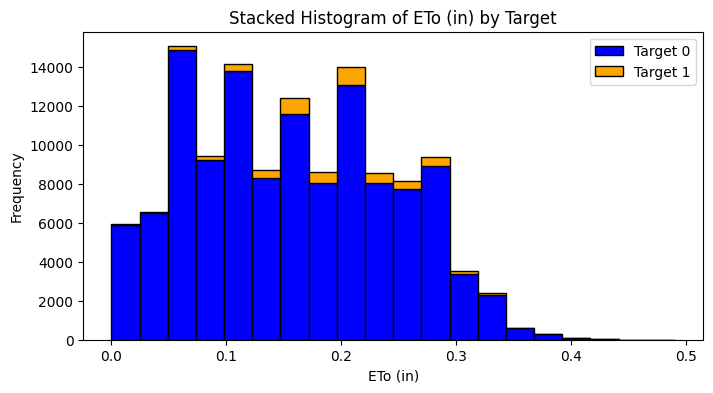

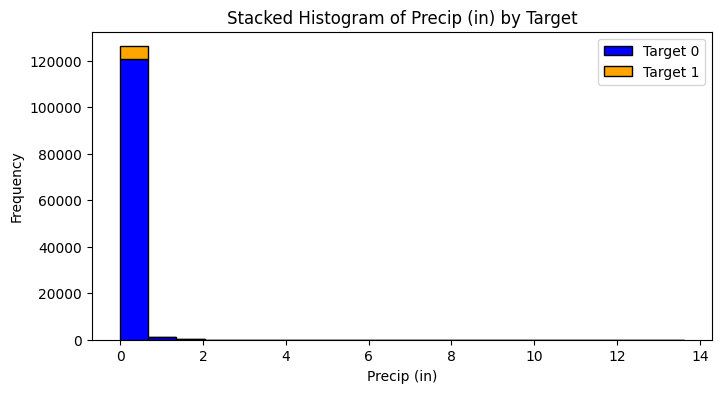

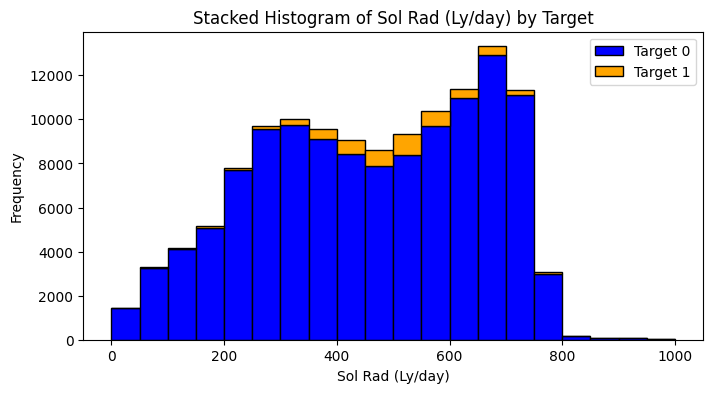

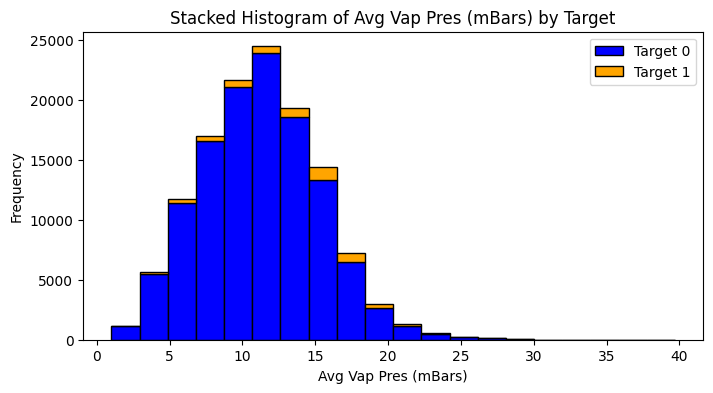

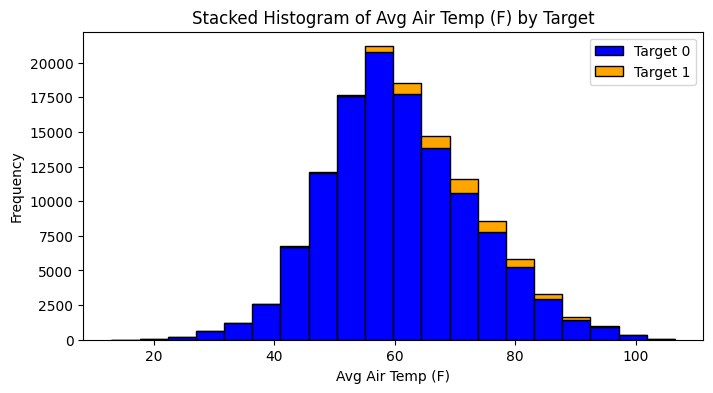

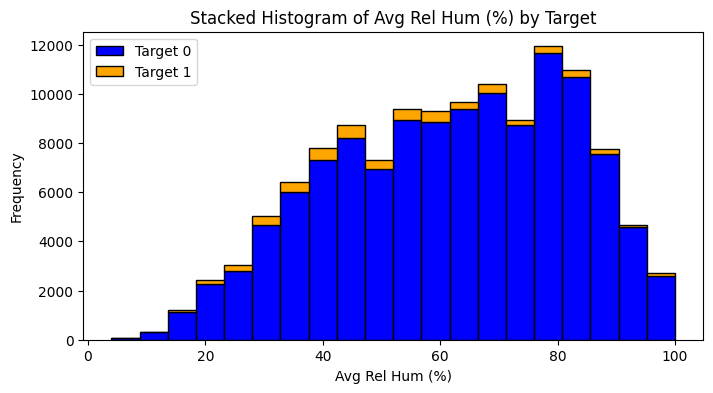

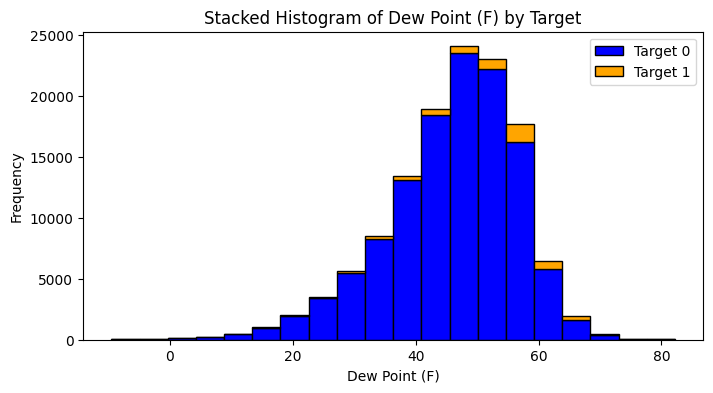

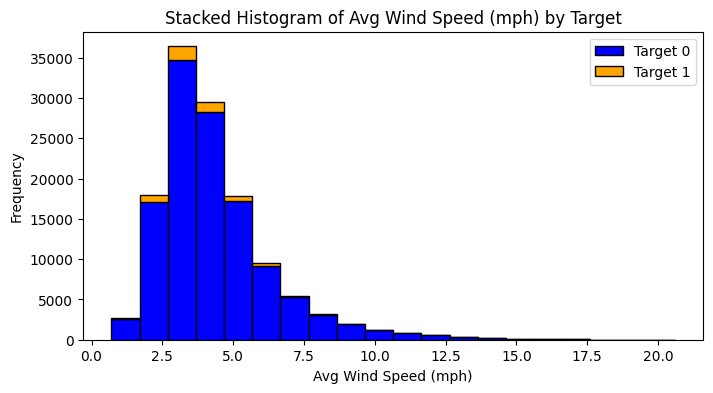

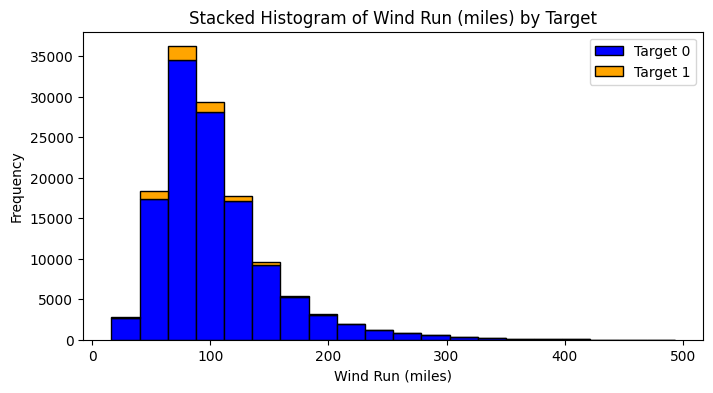

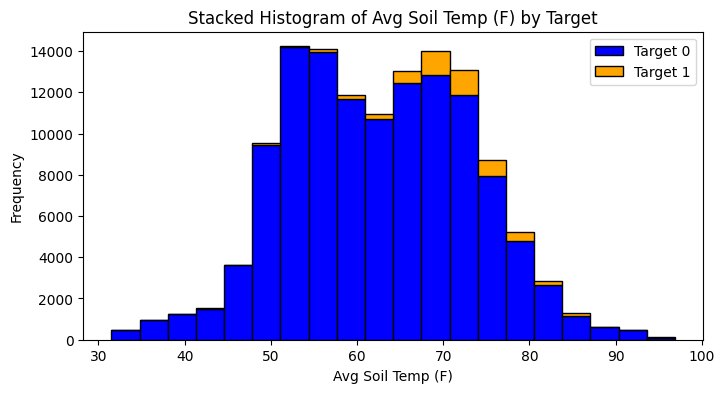

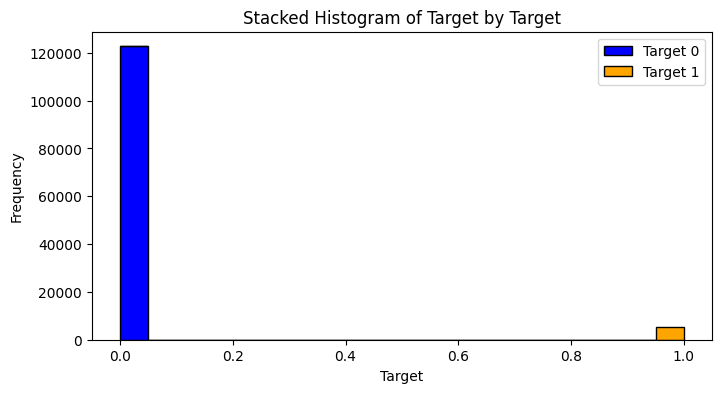

In [10]:
# Select numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Plot stacked histograms for each numerical column based on Target values
for column in numerical_columns:
    plt.figure(figsize=(8, 4))

    # Plot stacked histograms
    plt.hist([df[df['Target'] == 0][column], df[df['Target'] == 1][column]], bins=20, edgecolor='black', stacked=True, label=['Target 0', 'Target 1'], color=['blue', 'orange'])

    plt.title(f'Stacked Histogram of {column} by Target')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()  # Show legend to differentiate between Target values
    plt.show()

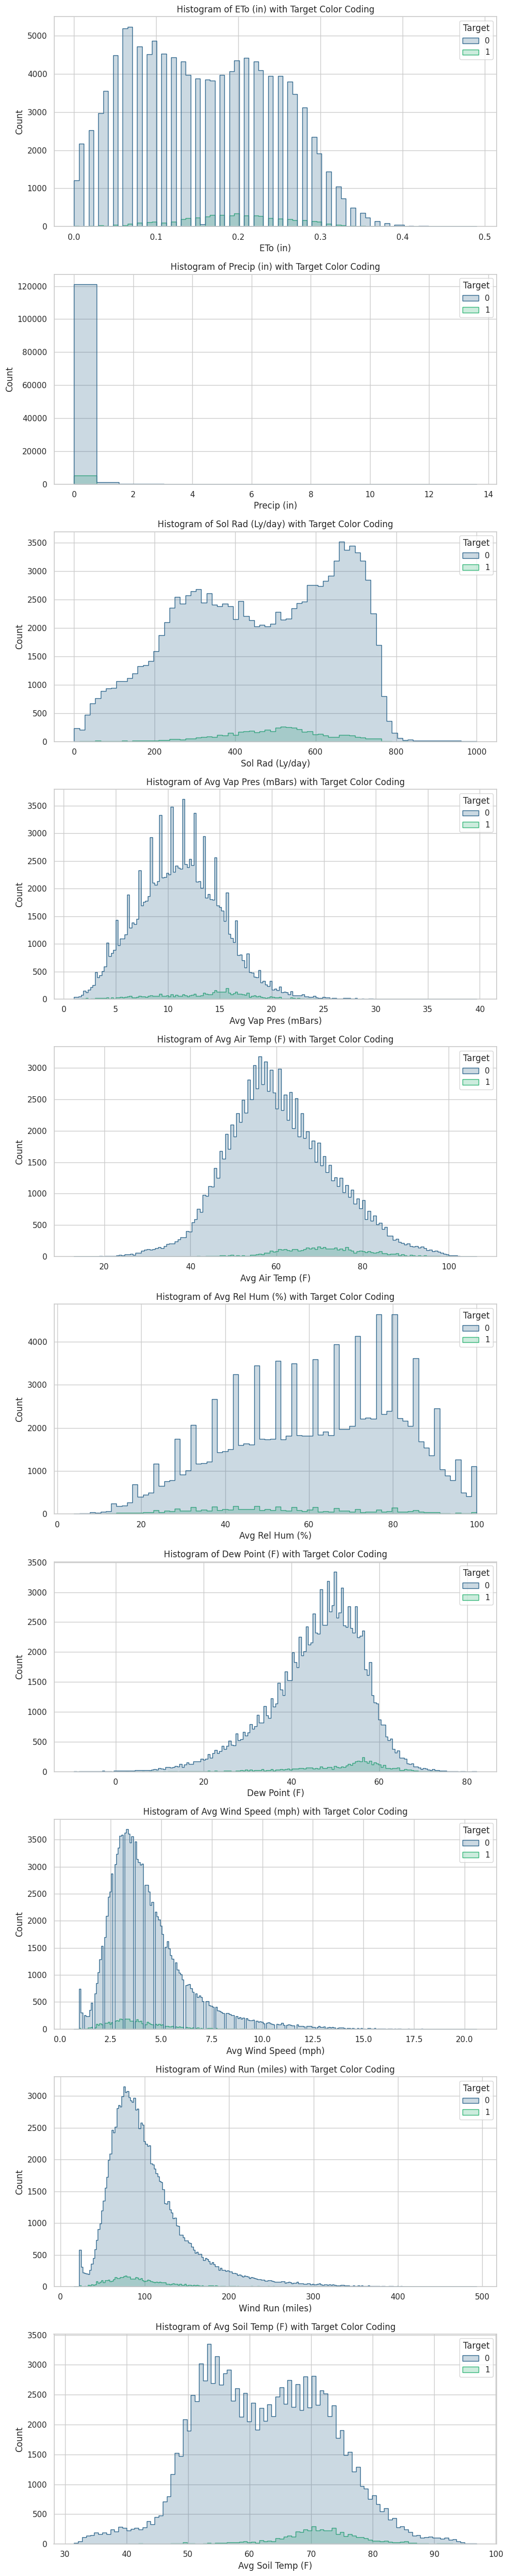

In [11]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Histogram for each column with color coding for 'Target'
columns = df.columns.drop('Target')  # All columns except 'Target'

# Creating a figure with subplots
fig, axes = plt.subplots(len(columns), 1, figsize=(10, 5 * len(columns)))

# Looping through each column and creating a histogram
for i, col in enumerate(columns):
    sns.histplot(data=df, x=col, hue="Target", element="step", ax=axes[i], palette="viridis")
    axes[i].set_title(f'Histogram of {col} with Target Color Coding')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Correlation, Outlier and Distribution Analyses

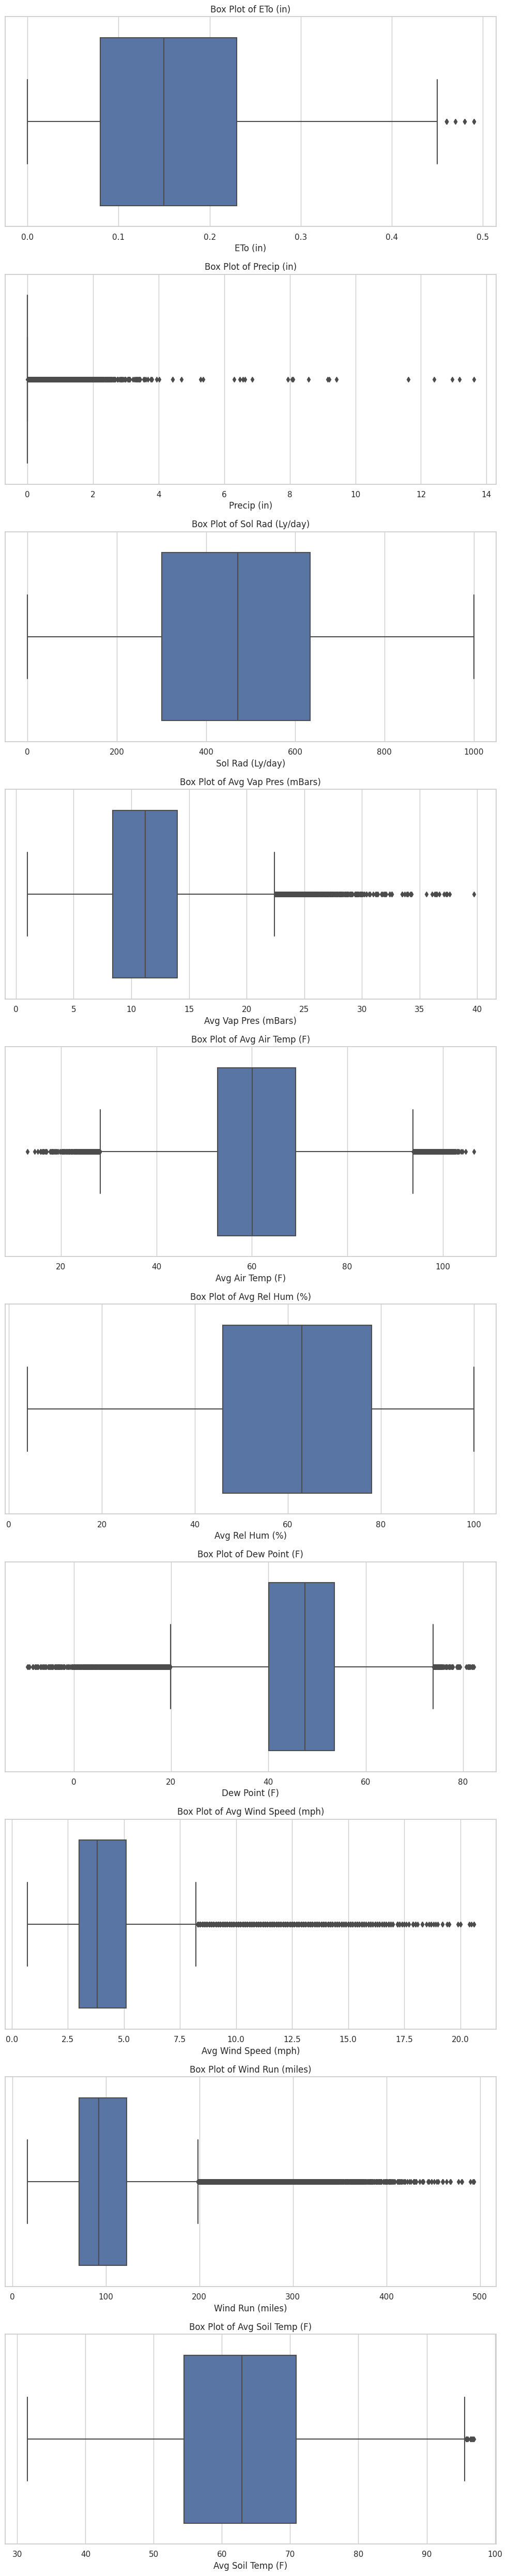

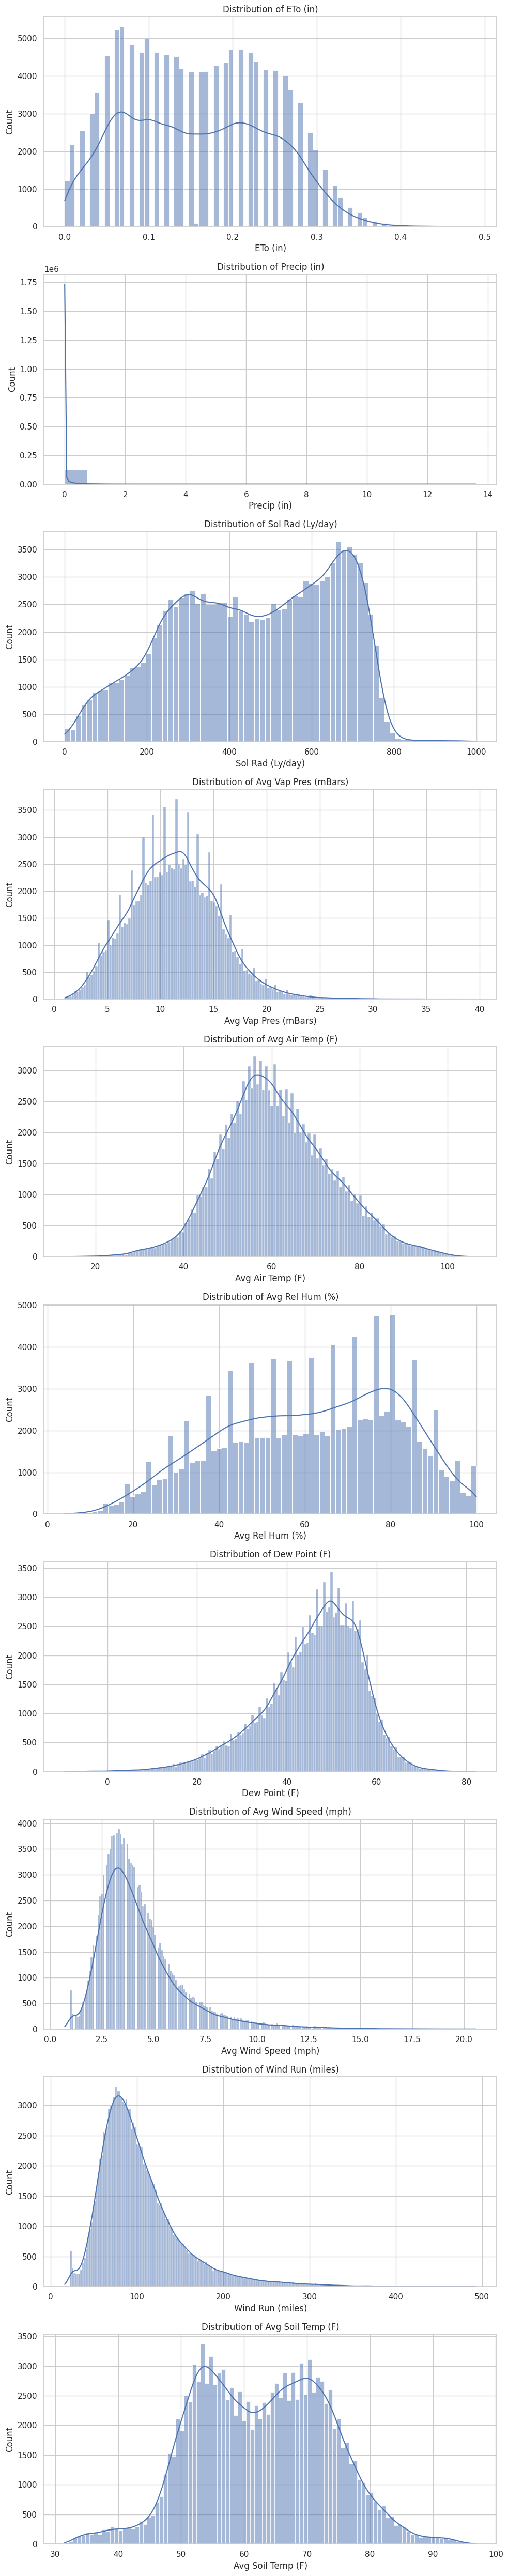

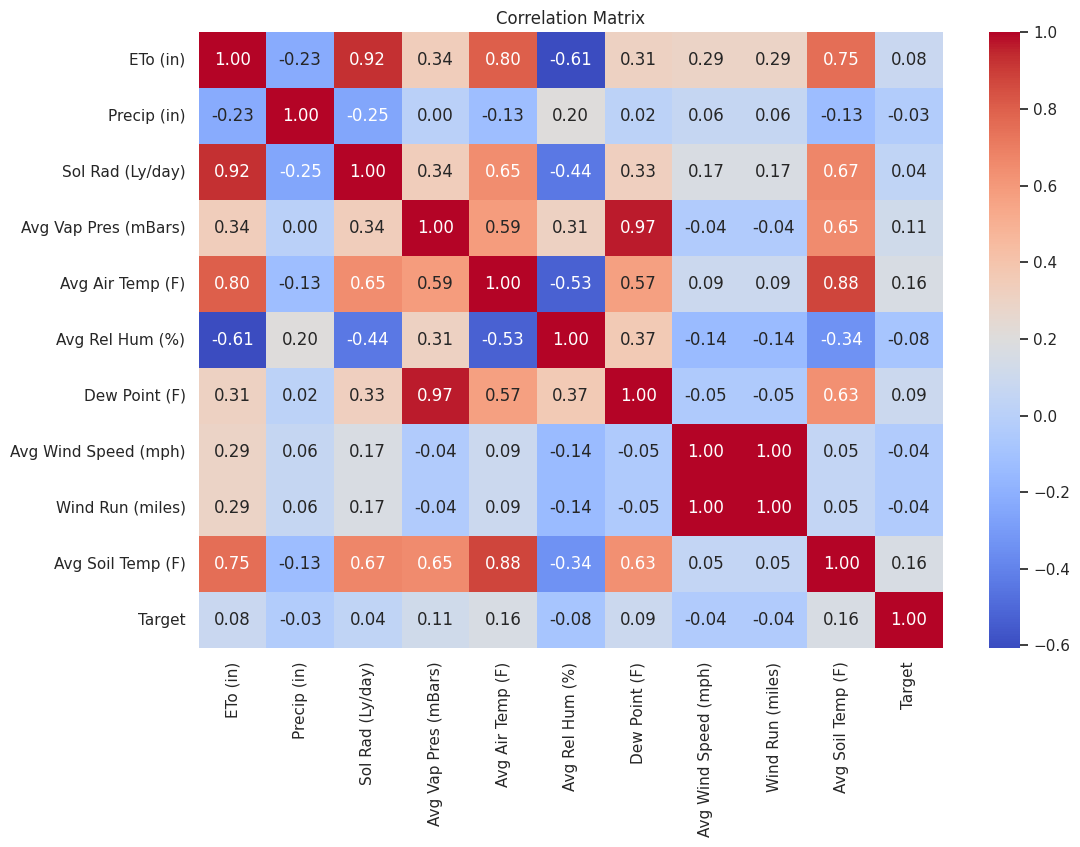

In [12]:
# Correlation Analysis, Outlier Analysis, and Distribution Analysis

# Correlation Analysis
corr_matrix = df.corr()

# Outlier Analysis using Box Plots
fig, axes = plt.subplots(len(columns), 1, figsize=(10, 5 * len(columns)))
for i, col in enumerate(columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')
plt.tight_layout()

# Distribution Analysis
# Plotting histograms to understand the distribution
fig, axes = plt.subplots(len(columns), 1, figsize=(10, 5 * len(columns)))
for i, col in enumerate(columns):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()

# Displaying the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Assumptions Tests

### Multicollinearity Test

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Preparing the data for VIF calculation: excluding the target variable and adding a constant for the intercept
X = df.drop('Target', axis=1)
X = X._get_numeric_data()  # ensuring all variables are numeric
X['Intercept'] = 1

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Interpretation: A VIF above 5 or 10 indicates high multicollinearity
vif_data.sort_values('VIF', ascending=False)

,Feature,VIF
8,Wind Run (miles),4938.348726
7,Avg Wind Speed (mph),4937.789193
10,Intercept,502.512371
6,Dew Point (F),34.424268
4,Avg Air Temp (F),32.009965
0,ETo (in),27.347115
5,Avg Rel Hum (%),21.028060
3,Avg Vap Pres (mBars),16.371476
2,Sol Rad (Ly/day),13.823579
9,Avg Soil Temp (F),5.502539


High VIF Values: The columns 'Wind Run (miles)' and 'Avg Wind Speed (mph)' have extremely high VIF values, indicating significant multicollinearity. This suggests that these features are highly linearly related to each other.
Moderately High VIF Values: Features like 'Dew Point (F)', 'Avg Air Temp (F)', 'ETo (in)', 'Avg Rel Hum (%)', 'Avg Vap Pres (mBars)', and 'Sol Rad (Ly/day)' have moderately high VIF values, indicating a moderate level of multicollinearity.
Acceptable VIF Values: 'Avg Soil Temp (F)' and 'Precip (in)' have acceptable VIF values.
Interpretation and Next Steps:
High Multicollinearity: The high VIF values for 'Wind Run (miles)' and 'Avg Wind Speed (mph)' suggest that one of these variables might need to be dropped or transformed to reduce multicollinearity.
Moderate Multicollinearity: The features with moderately high VIF values might also need attention.

#### Dropping Wind Run (miles) to Reduce Multicollinearity

In [14]:
df = df.drop('Wind Run (miles)', axis=1)

#### Perform Test Again

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Preparing the data for VIF calculation: excluding the target variable and adding a constant for the intercept
X = df.drop('Target', axis=1)
X = X._get_numeric_data()  # ensuring all variables are numeric
X['Intercept'] = 1

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Interpretation: A VIF above 5 or 10 indicates high multicollinearity
vif_data.sort_values('VIF', ascending=False)

,Feature,VIF
9,Intercept,502.491365
6,Dew Point (F),34.424266
4,Avg Air Temp (F),32.009295
0,ETo (in),27.344237
5,Avg Rel Hum (%),21.028059
3,Avg Vap Pres (mBars),16.371381
2,Sol Rad (Ly/day),13.822642
8,Avg Soil Temp (F),5.502532
7,Avg Wind Speed (mph),1.560803
1,Precip (in),1.119761


### Shapiro-Wilk's Test

In [16]:
from scipy.stats import shapiro

# Normality Test (Shapiro-Wilk)
normality_test_results = pd.DataFrame(columns=['Feature', 'Shapiro_Stat', 'p-value'])

for col in X.drop('Intercept', axis=1).columns:  # Excluding the Intercept
    stat, p = shapiro(X[col])
    normality_test_results = normality_test_results.append({'Feature': col, 'Shapiro_Stat': stat, 'p-value': p}, ignore_index=True)

normality_test_results.set_index('Feature', inplace=True)
normality_test_results

,Shapiro_Stat,p-value
Feature,,
ETo (in),0.973996,0.0
Precip (in),0.174779,0.0
Sol Rad (Ly/day),0.964184,0.0
Avg Vap Pres (mBars),0.991413,0.0
Avg Air Temp (F),0.994004,0.0
Avg Rel Hum (%),0.977466,0.0
Dew Point (F),0.967982,0.0
Avg Wind Speed (mph),0.870968,0.0
Avg Soil Temp (F),0.993298,0.0


Interpretation:
Since the p-values are essentially zero for all features, this suggests that the distributions of these variables do not follow a normal distribution.
However, it's important to note that for logistic regression, the normality of independent variables is not a strict requirement as it is for linear regression.
The Shapiro-Wilk test is also very sensitive, especially with large sample sizes, so small deviations from normality can lead to rejection of the null hypothesis.
Given the large sample size in your dataset, these results are not unusual and may not be a significant concern for logistic regression.

### Shapiro-Wilk's Test with 30% of Sample Size

In [17]:
# Normality Test (Shapiro-Wilk) using a random 30% sample of each feature
normality_test_results = pd.DataFrame(columns=['Feature', 'Shapiro_Stat', 'p-value'])
sample_size = int(len(X) * 0.3)  # 30% of the sample size

for col in X.drop('Intercept', axis=1).columns:  # Excluding the 'Intercept' column
    # Take a random sample of about 30% of the data
    sample = X[col].sample(sample_size)
    stat, p = shapiro(sample)
    normality_test_results = normality_test_results.append({'Feature': col, 'Shapiro_Stat': stat, 'p-value': p}, ignore_index=True)

normality_test_results.set_index('Feature', inplace=True)
normality_test_results

,Shapiro_Stat,p-value
Feature,,
ETo (in),0.973382,0.000000e+00
Precip (in),0.170053,0.000000e+00
Sol Rad (Ly/day),0.965052,0.000000e+00
Avg Vap Pres (mBars),0.990700,1.036961e-42
Avg Air Temp (F),0.993859,3.632938e-36
Avg Rel Hum (%),0.977726,0.000000e+00
Dew Point (F),0.968667,0.000000e+00
Avg Wind Speed (mph),0.868174,0.000000e+00
Avg Soil Temp (F),0.993792,2.490661e-36


### D^2 Agostino's Test

In [18]:
from scipy.stats import normaltest

target_column = 'Target'

# Get the numerical columns excluding the target variable
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in numerical_columns if col != target_column]

# Perform D'Agostino's K^2 test for each numerical column
for column in numerical_columns:
    data = df[column]
    stat, p_value = normaltest(data)

    # Check the p-value
    alpha = 0.05
    if p_value > alpha:
        print(f"The data in column '{column}' appears to be normally distributed (p-value = {p_value:.4f})")
    else:
        print(f"The data in column '{column}' does not appear to be normally distributed (p-value = {p_value:.4f})")

The data in column 'ETo (in)' does not appear to be normally distributed (p-value = 0.0000)
The data in column 'Precip (in)' does not appear to be normally distributed (p-value = 0.0000)
The data in column 'Sol Rad (Ly/day)' does not appear to be normally distributed (p-value = 0.0000)
The data in column 'Avg Vap Pres (mBars)' does not appear to be normally distributed (p-value = 0.0000)
The data in column 'Avg Air Temp (F)' does not appear to be normally distributed (p-value = 0.0000)
The data in column 'Avg Rel Hum (%)' does not appear to be normally distributed (p-value = 0.0000)
The data in column 'Dew Point (F)' does not appear to be normally distributed (p-value = 0.0000)
The data in column 'Avg Wind Speed (mph)' does not appear to be normally distributed (p-value = 0.0000)
The data in column 'Avg Soil Temp (F)' does not appear to be normally distributed (p-value = 0.0000)


### Anderson-Darling Test

In [19]:
from scipy.stats import anderson

# Perform Anderson-Darling test for each numerical column
for column in numerical_columns:
    data = df[column]
    result = anderson(data)

    # Check the critical values
    critical_values = result.critical_values
    significance_level = result.significance_level

    # Print the results
    print(f"Results for column '{column}':")
    print(f"Statistic: {result.statistic:.4f}")
    print(f"Critical Values: {critical_values}")
    print(f"Significance Level: {significance_level}")
    print(f"The data in column '{column}' is likely {'not ' if result.statistic > critical_values[2] else ''}normally distributed.")
    print()

Results for column 'ETo (in)':
Statistic: 979.7946
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Level: [15.  10.   5.   2.5  1. ]
The data in column 'ETo (in)' is likely not normally distributed.

Results for column 'Precip (in)':
Statistic: 37858.0944
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Level: [15.  10.   5.   2.5  1. ]
The data in column 'Precip (in)' is likely not normally distributed.

Results for column 'Sol Rad (Ly/day)':
Statistic: 1361.4672
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Level: [15.  10.   5.   2.5  1. ]
The data in column 'Sol Rad (Ly/day)' is likely not normally distributed.

Results for column 'Avg Vap Pres (mBars)':
Statistic: 77.9663
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Level: [15.  10.   5.   2.5  1. ]
The data in column 'Avg Vap Pres (mBars)' is likely not normally distributed.

Results for column 'Avg Air Temp (F)':
Statistic: 284.0411
Critical Values: [0.576 0.656 0.787 0

### Significance Test

In [20]:
import statsmodels.api as sm

# Assuming X is your feature and y is your dependent variable
X = df.drop('Target', axis=1)
y = df['Target']

# Add a constant term (intercept) to the independent variable
X = sm.add_constant(X)

# Fit a linear regression model
model = sm.OLS(y, X).fit()

# Get the summary of the regression analysis
summary = model.summary()

# Print the summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     711.4
Date:                Sat, 18 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:48:11   Log-Likelihood:                 27387.
No. Observations:              128007   AIC:                        -5.475e+04
Df Residuals:                  127997   BIC:                        -5.466e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0484 

### Outlier Detection Test

Optimization terminated successfully.
         Current function value: 0.153013
         Iterations 10


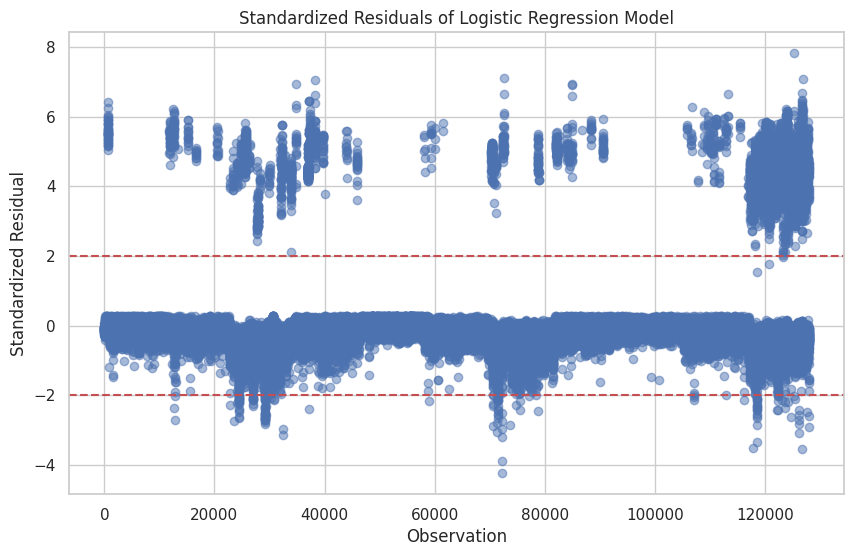

5499

In [21]:
# Preparing the data for the logistic regression model
X_outlier = df.drop('Target', axis=1)
y = df['Target']

# Adding a constant to X for the intercept
X = sm.add_constant(X_outlier)

# Defining the logistic regression model
logit_model = sm.Logit(y, X_outlier)

# Fitting the model
logit_result = logit_model.fit()

# Calculating standardized residuals for the logistic regression model
residuals = logit_result.resid_dev  # Deviance residuals
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Plotting the standardized residuals
plt.figure(figsize=(10, 6))
plt.scatter(x=range(len(standardized_residuals)), y=standardized_residuals, alpha=0.5)
plt.axhline(y=2, color='r', linestyle='--')  # Rough threshold for potential outliers
plt.axhline(y=-2, color='r', linestyle='--')
plt.title("Standardized Residuals of Logistic Regression Model")
plt.xlabel("Observation")
plt.ylabel("Standardized Residual")
plt.show()

# Identifying potential outliers (arbitrary threshold +/- 2)
outlier_indices = np.where((standardized_residuals > 2) | (standardized_residuals < -2))[0]
len(outlier_indices)


Interpretation:
Outliers: There are 5499 observations with standardized residuals greater than 2 or less than -2. These could be potential outliers.

In [22]:
# Investigating the potential outliers identified by the standardized residuals

# Adding standardized residuals to the DataFrame
df['Standardized_Residuals'] = standardized_residuals

# Filtering the DataFrame for potential outliers
outliers_df = df.iloc[outlier_indices]

# Make sure to update 'columns' list if it contains dropped columns
# For example, if 'Wind Run (miles)' was in 'columns', remove it
columns = [col for col in columns if col in df.columns]

# Displaying a sample of the potential outliers
outliers_sample = outliers_df.sample(10, random_state=42)  # Random sample of 10 potential outliers
outliers_sample[['Standardized_Residuals'] + columns]  # Displaying the relevant columns

,Standardized_Residuals,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Avg Air Temp (F),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Avg Soil Temp (F)
126437,4.666300,0.21,0.00,567.0,18.3,72.1,68.0,61.0,3.8,71.4
72499,4.922279,0.26,0.00,633.0,10.2,69.6,41.0,45.1,4.5,69.4
127265,5.044469,0.19,0.00,469.0,7.9,59.5,46.0,38.5,4.9,62.9
125629,3.709610,0.11,0.00,312.0,19.1,73.3,68.0,62.2,3.4,75.2
118333,4.118012,0.31,0.00,689.0,10.3,78.3,31.0,45.3,5.7,88.3
122239,3.350782,0.08,0.00,262.0,18.2,68.2,77.0,60.9,1.6,80.0
25523,5.823426,0.20,0.31,473.0,14.4,66.4,65.0,54.3,6.3,66.5
694,5.998268,0.18,0.00,559.0,2.3,45.7,22.0,9.2,7.3,48.5
123034,3.540364,0.16,0.00,316.0,15.1,79.8,44.0,55.6,3.9,74.5
123644,4.051732,0.14,0.00,428.0,16.4,69.3,67.0,57.8,2.3,75.8


### Homoscedasticity Test

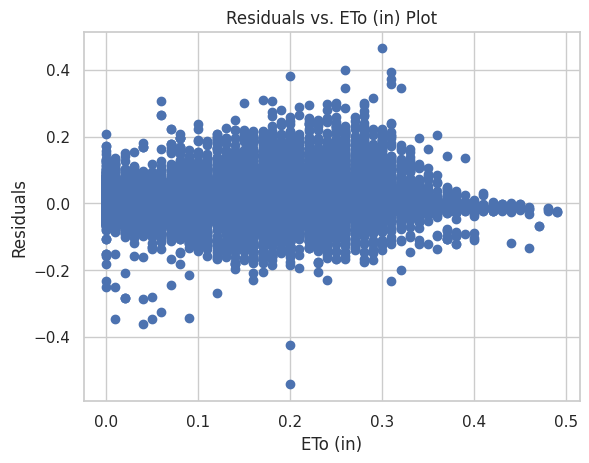

P-value for homoscedasticity test (ETo (in)): 0.0


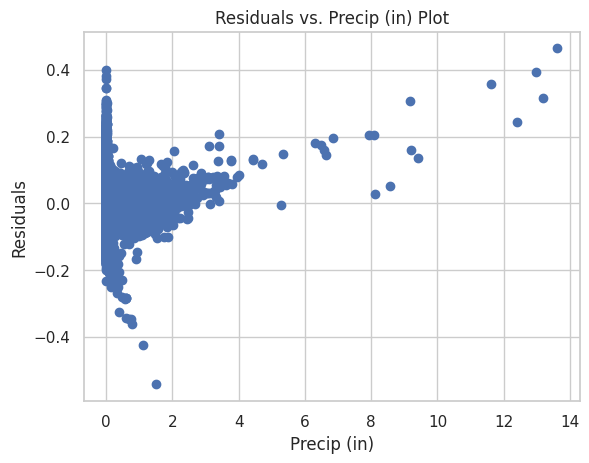

P-value for homoscedasticity test (Precip (in)): 0.0


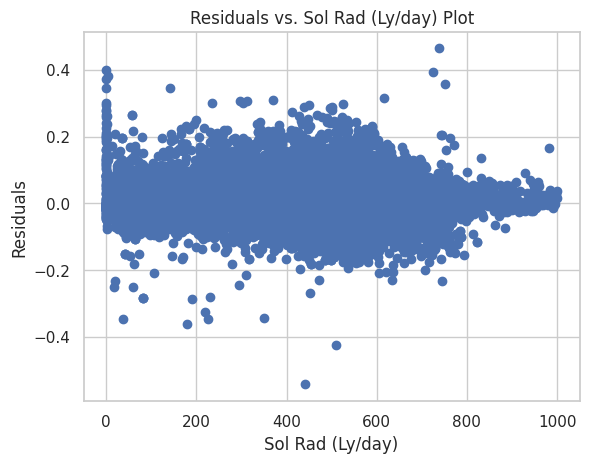

P-value for homoscedasticity test (Sol Rad (Ly/day)): 0.0


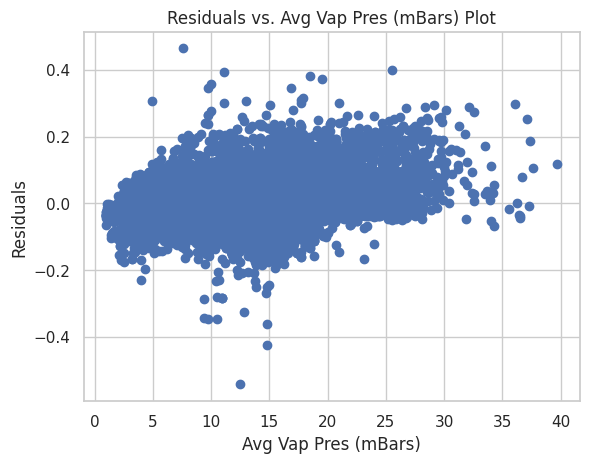

P-value for homoscedasticity test (Avg Vap Pres (mBars)): 0.0


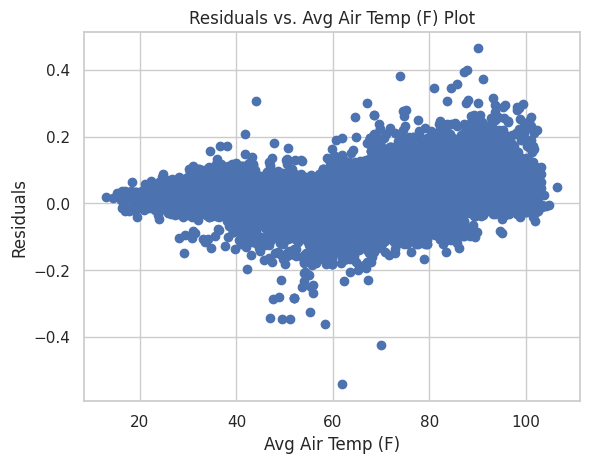

P-value for homoscedasticity test (Avg Air Temp (F)): 0.0


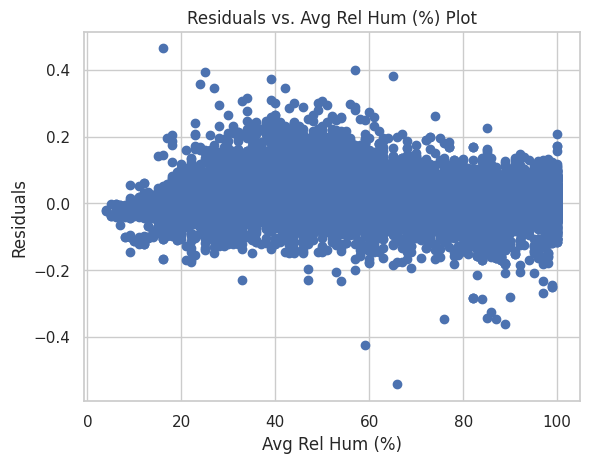

P-value for homoscedasticity test (Avg Rel Hum (%)): 0.0


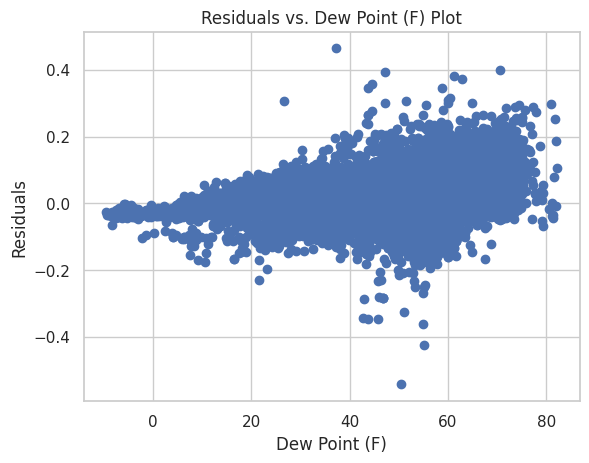

P-value for homoscedasticity test (Dew Point (F)): 0.0


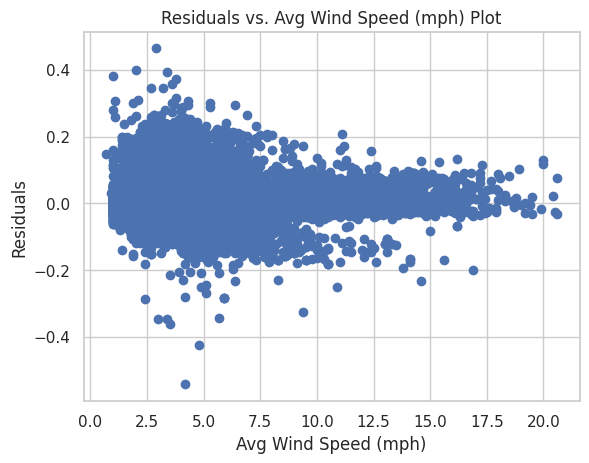

P-value for homoscedasticity test (Avg Wind Speed (mph)): 0.0


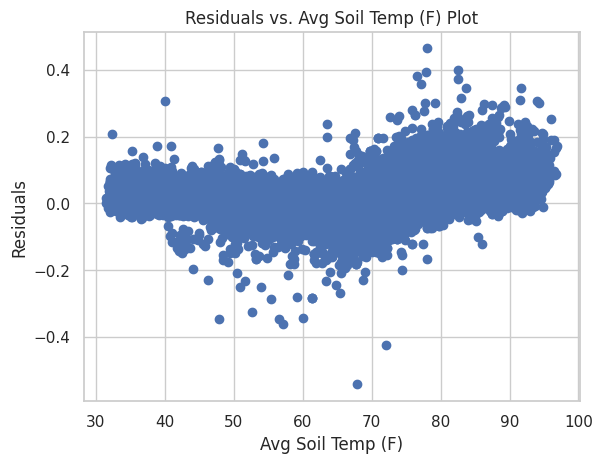

P-value for homoscedasticity test (Avg Soil Temp (F)): 0.0


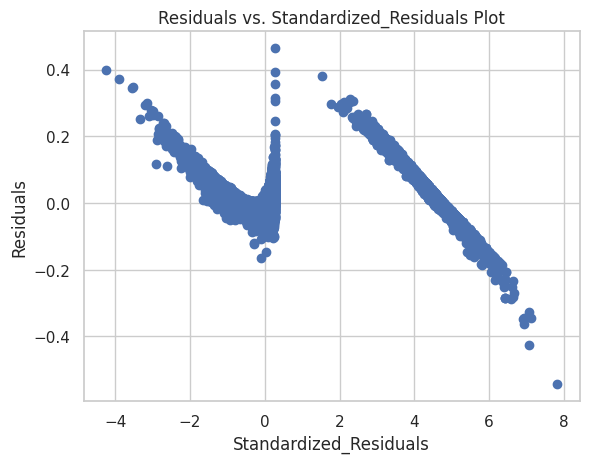

P-value for homoscedasticity test (Standardized_Residuals): 0.0


In [23]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Assuming you have a model named 'model' and the data is stored in a DataFrame named 'df'
X = df.drop(['Target'], axis=1)
X_with_const = sm.add_constant(X)
y = df['Target']

model = sm.OLS(y, X_with_const)
results = model.fit()
residuals = results.resid

# Loop through each independent variable and create scatterplot
for column in X.columns:
    plt.scatter(X[column], residuals)
    plt.xlabel(column)
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. {column} Plot')
    plt.show()

    # Perform Breusch-Pagan test
    _, p_value, _, _ = het_breuschpagan(residuals, X_with_const)

    # Display the p-value
    print(f"P-value for homoscedasticity test ({column}): {p_value}")

Interpretation:
The null hypothesis of the Breusch-Pagan test is that the variance of the residuals is constant (homoscedasticity).
A low p-value (typically < 0.05) suggests rejecting the null hypothesis, indicating the presence of heteroscedasticity (variance of the residuals is not constant across the range of independent variables).
In this case, with a p-value much lower than 0.05, there is evidence of heteroscedasticity in the model.

# Feature Engineering

## Adding New Target 'Intensity Level'

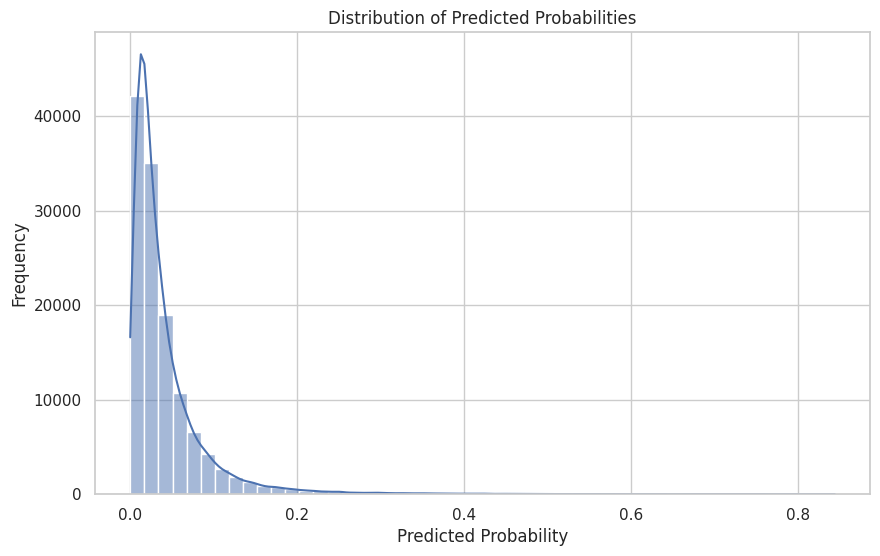

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Splitting the data into training and testing sets
X = df.drop(['Target', 'Standardized_Residuals'], axis=1)  # Excluding target and residuals
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Generating probabilities for the positive class (Target = 1)
probabilities = log_reg.predict_proba(X)[:, 1]  # Probabilities of the positive class

# Plotting the distribution of predicted probabilities

plt.figure(figsize=(10, 6))
sns.histplot(probabilities, bins=50, kde=True)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

In [25]:
# Summary statistics for the predicted probabilities
probabilities_summary = pd.Series(probabilities).describe()
probabilities_summary

count    1.280070e+05
mean     4.180419e-02
std      5.208751e-02
min      3.392478e-31
25%      1.348957e-02
50%      2.604458e-02
75%      5.046834e-02
max      8.438670e-01
dtype: float64

In [26]:
# Updating 'Intensity Level' based on new thresholds
new_thresholds = [0, 0.013, 0.0505, 0.844]
df['Intensity Level'] = pd.cut(probabilities, bins=new_thresholds, labels=['Low', 'Medium', 'High'], right=False)

# Displaying a sample of the DataFrame with the updated 'Intensity Level'
updated_sample_with_intensity = df.sample(10, random_state=42)  # Random sample of 10 rows
updated_sample_with_intensity[['Intensity Level'] + list(columns) + ['Target']]  # Displaying relevant columns

,Intensity Level,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Avg Air Temp (F),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Avg Soil Temp (F),Target
21795,Medium,0.29,0.00,746.0,15.3,74.8,52.0,56.1,5.4,70.1,0
115135,Low,0.20,0.01,621.0,6.9,45.0,68.0,35.0,7.7,63.8,0
35332,Medium,0.07,0.00,303.0,2.9,36.7,40.0,14.5,3.0,43.1,0
13999,Medium,0.28,0.00,707.0,9.8,63.6,49.0,44.0,6.3,65.7,0
23723,Medium,0.20,0.00,552.0,9.5,65.8,44.0,43.3,2.9,67.0,0
74037,Medium,0.35,0.00,725.0,9.7,92.5,19.0,43.9,5.6,77.5,0
11237,Medium,0.26,0.00,624.0,9.0,70.1,36.0,41.9,5.5,62.9,0
49510,Low,0.05,0.00,218.0,6.4,40.3,76.0,33.2,2.0,44.6,0
59552,Low,0.18,0.00,583.0,4.5,44.2,45.0,24.3,7.3,49.3,0
77741,Medium,0.19,0.00,628.0,14.8,60.7,82.0,55.1,4.6,70.2,0


In [27]:
df

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Avg Air Temp (F),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Avg Soil Temp (F),Target,Standardized_Residuals,Intensity Level
0,0.06,0.00,219.0,7.3,47.8,65.0,36.6,3.3,51.1,0,-0.164036,Medium
1,0.04,0.00,127.0,7.4,47.2,67.0,36.7,3.1,51.3,0,-0.254253,Medium
2,0.04,0.00,125.0,8.4,49.9,68.0,39.9,4.5,51.3,0,-0.192357,Medium
3,0.07,0.01,219.0,11.6,56.8,74.0,48.5,5.8,53.0,0,-0.072059,Medium
4,0.07,0.00,239.0,12.7,59.8,72.0,50.8,4.2,54.4,0,-0.163309,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...
128120,0.14,0.00,420.0,15.4,66.3,70.0,56.2,3.4,69.4,1,4.665367,High
128121,0.15,0.00,430.0,15.1,66.0,69.0,55.7,2.7,69.0,1,4.566465,High
128122,0.15,0.00,445.0,16.2,68.0,69.0,57.6,3.3,69.0,1,4.649700,High
128123,0.16,0.00,447.0,16.6,70.4,65.0,58.3,3.3,69.5,1,4.471823,High


In [28]:
df.drop('Target', axis=1, inplace=True)
df

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Avg Air Temp (F),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Avg Soil Temp (F),Standardized_Residuals,Intensity Level
0,0.06,0.00,219.0,7.3,47.8,65.0,36.6,3.3,51.1,-0.164036,Medium
1,0.04,0.00,127.0,7.4,47.2,67.0,36.7,3.1,51.3,-0.254253,Medium
2,0.04,0.00,125.0,8.4,49.9,68.0,39.9,4.5,51.3,-0.192357,Medium
3,0.07,0.01,219.0,11.6,56.8,74.0,48.5,5.8,53.0,-0.072059,Medium
4,0.07,0.00,239.0,12.7,59.8,72.0,50.8,4.2,54.4,-0.163309,Medium
...,...,...,...,...,...,...,...,...,...,...,...
128120,0.14,0.00,420.0,15.4,66.3,70.0,56.2,3.4,69.4,4.665367,High
128121,0.15,0.00,430.0,15.1,66.0,69.0,55.7,2.7,69.0,4.566465,High
128122,0.15,0.00,445.0,16.2,68.0,69.0,57.6,3.3,69.0,4.649700,High
128123,0.16,0.00,447.0,16.6,70.4,65.0,58.3,3.3,69.5,4.471823,High


In [29]:
df.columns

Index(['ETo (in)', 'Precip (in)', 'Sol Rad (Ly/day)', 'Avg Vap Pres (mBars)',
       'Avg Air Temp (F)', 'Avg Rel Hum (%)', 'Dew Point (F)',
       'Avg Wind Speed (mph)', 'Avg Soil Temp (F)', 'Standardized_Residuals',
       'Intensity Level'],
      dtype='object')

In [30]:
numerical_features= ['ETo (in)', 'Precip (in)', 'Sol Rad (Ly/day)', 'Avg Vap Pres (mBars)',
       'Avg Air Temp (F)', 'Avg Rel Hum (%)', 'Dew Point (F)',
       'Avg Wind Speed (mph)', 'Avg Soil Temp (F)']
from sklearn.feature_selection import mutual_info_classif
X = df[numerical_features]

y = df['Intensity Level']
X.fillna(X.mean(), inplace=True)
mi_scores = mutual_info_classif(X, y)
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)


                Feature  Mutual Information
8     Avg Soil Temp (F)            0.302350
4      Avg Air Temp (F)            0.270668
1           Precip (in)            0.095813
5       Avg Rel Hum (%)            0.093776
3  Avg Vap Pres (mBars)            0.088495
6         Dew Point (F)            0.087252
0              ETo (in)            0.071528
7  Avg Wind Speed (mph)            0.046294
2      Sol Rad (Ly/day)            0.041996


In [31]:
import pandas as pd
from sklearn.feature_selection import f_classif


# Assuming 'Intensity Level' is your target variable for classification
X = df[numerical_features]

y = df['Intensity Level']

# Fill missing values with the mean
X.fillna(X.mean(), inplace=True)

# Calculate F-statistics for feature selection
f_scores, _ = f_classif(X, y)

# Create a DataFrame to store feature names and their F-scores
f_scores_df = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores})

# Sort the DataFrame by F-Score in descending order
f_scores_df = f_scores_df.sort_values(by='F-Score', ascending=False)

# Print the DataFrame with feature names and their F-Scores
print(f_scores_df)


                Feature       F-Score
8     Avg Soil Temp (F)  48195.405032
4      Avg Air Temp (F)  46028.763070
5       Avg Rel Hum (%)  12797.605268
3  Avg Vap Pres (mBars)  10510.794234
0              ETo (in)   8580.177722
6         Dew Point (F)   7906.541459
7  Avg Wind Speed (mph)   6572.921601
1           Precip (in)   6048.326120
2      Sol Rad (Ly/day)   2842.749511


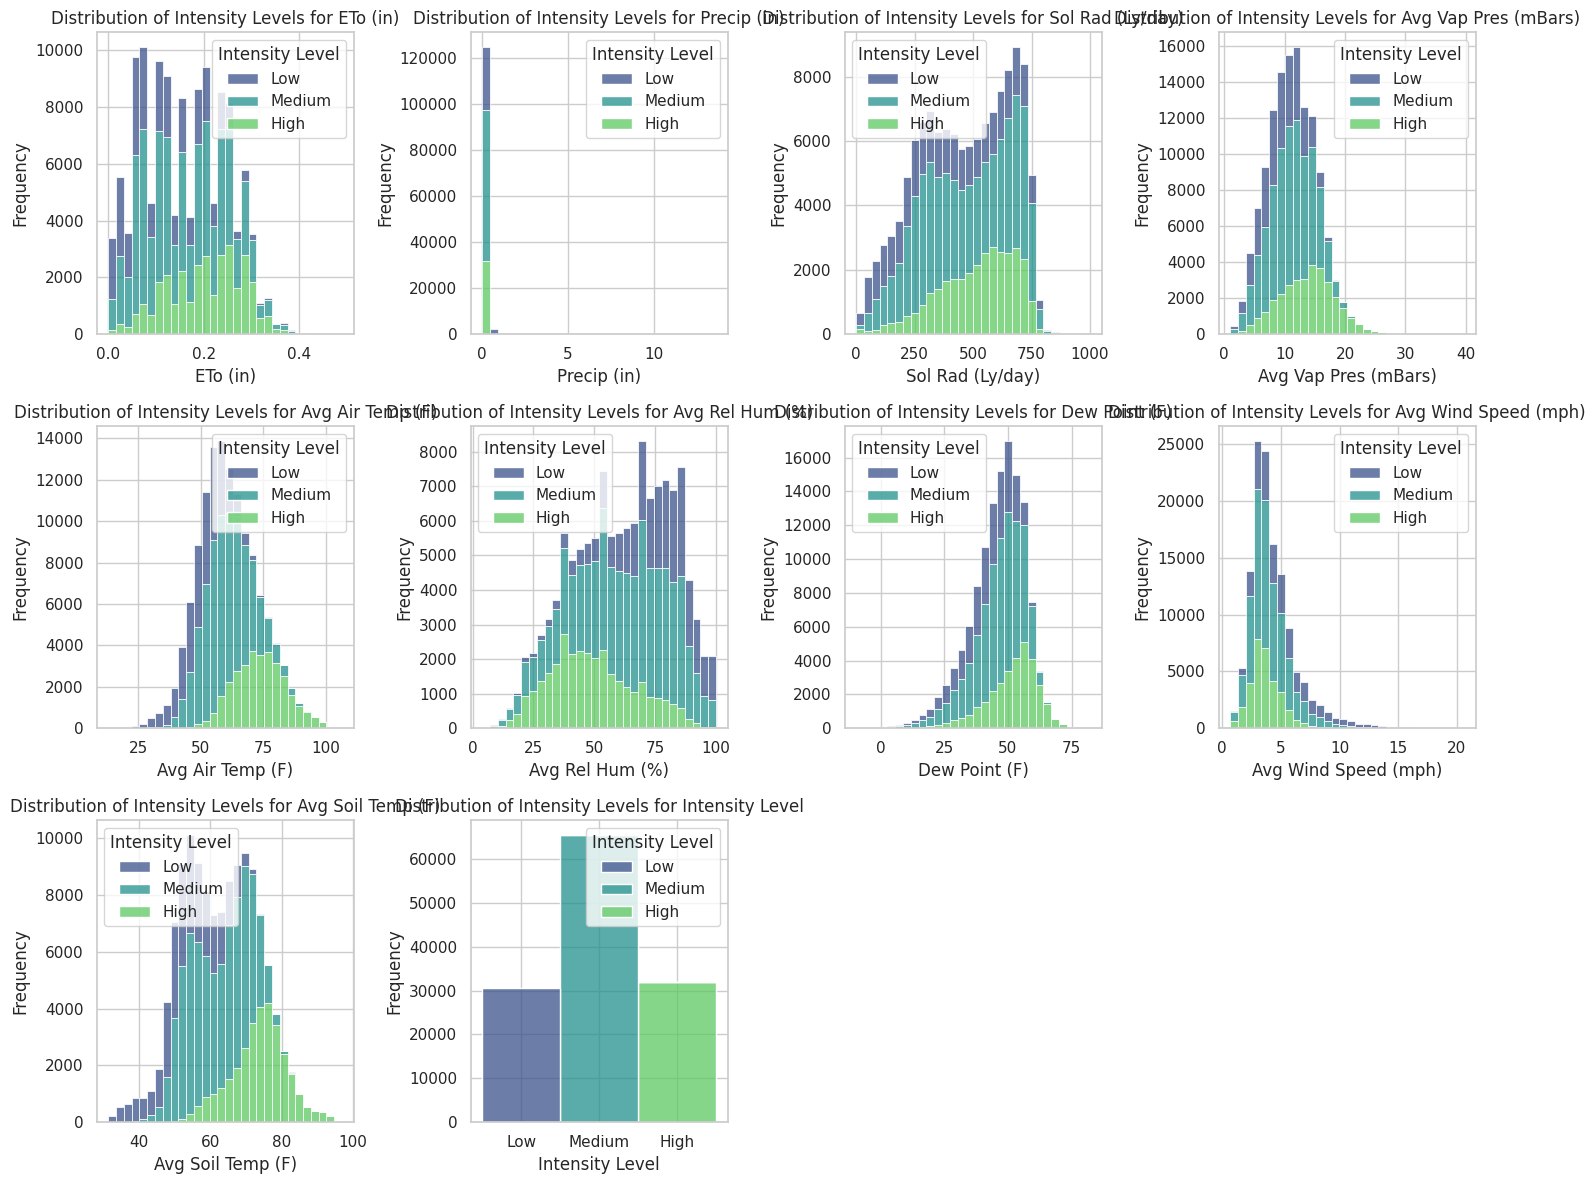

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of weather conditions
weather_conditions = ['ETo (in)', 'Precip (in)', 'Sol Rad (Ly/day)', 'Avg Vap Pres (mBars)',
                      'Avg Air Temp (F)', 'Avg Rel Hum (%)', 'Dew Point (F)',
                      'Avg Wind Speed (mph)', 'Avg Soil Temp (F)', 'Intensity Level']

# Set the figure size
plt.figure(figsize=(15, 12))

# Loop through each weather condition and create a separate subplot
for i, condition in enumerate(weather_conditions, start=1):
    plt.subplot(3, 4, i)  # Updated subplot dimensions to accommodate the new variable
    sns.histplot(data=df, x=condition, hue='Intensity Level', multiple='stack', bins=30, palette='viridis')
    plt.xlabel(condition)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Intensity Levels for {condition}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [33]:
# Drop Standardardized Residuals
df = df.drop(['Standardized_Residuals'], axis=1)

In [34]:
df

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Avg Air Temp (F),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Avg Soil Temp (F),Intensity Level
0,0.06,0.00,219.0,7.3,47.8,65.0,36.6,3.3,51.1,Medium
1,0.04,0.00,127.0,7.4,47.2,67.0,36.7,3.1,51.3,Medium
2,0.04,0.00,125.0,8.4,49.9,68.0,39.9,4.5,51.3,Medium
3,0.07,0.01,219.0,11.6,56.8,74.0,48.5,5.8,53.0,Medium
4,0.07,0.00,239.0,12.7,59.8,72.0,50.8,4.2,54.4,Medium
...,...,...,...,...,...,...,...,...,...,...
128120,0.14,0.00,420.0,15.4,66.3,70.0,56.2,3.4,69.4,High
128121,0.15,0.00,430.0,15.1,66.0,69.0,55.7,2.7,69.0,High
128122,0.15,0.00,445.0,16.2,68.0,69.0,57.6,3.3,69.0,High
128123,0.16,0.00,447.0,16.6,70.4,65.0,58.3,3.3,69.5,High


# Model Comparison & Evaluation

## Splitting the Data & Mapping y

In [35]:
# Assuming df is your DataFrame
X = df.drop(['Intensity Level'], axis=1)
y = df['Intensity Level']

# Define a mapping for labels
label_mapping = {'Low': 0, 'Medium': 1, 'High': 2}

# Map the string labels to numerical labels for y
y = y.map(label_mapping)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Avg Air Temp (F),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Avg Soil Temp (F)
0,0.06,0.00,219.0,7.3,47.8,65.0,36.6,3.3,51.1
1,0.04,0.00,127.0,7.4,47.2,67.0,36.7,3.1,51.3
2,0.04,0.00,125.0,8.4,49.9,68.0,39.9,4.5,51.3
3,0.07,0.01,219.0,11.6,56.8,74.0,48.5,5.8,53.0
4,0.07,0.00,239.0,12.7,59.8,72.0,50.8,4.2,54.4
...,...,...,...,...,...,...,...,...,...
128120,0.14,0.00,420.0,15.4,66.3,70.0,56.2,3.4,69.4
128121,0.15,0.00,430.0,15.1,66.0,69.0,55.7,2.7,69.0
128122,0.15,0.00,445.0,16.2,68.0,69.0,57.6,3.3,69.0
128123,0.16,0.00,447.0,16.6,70.4,65.0,58.3,3.3,69.5


## Random Forest Classifier

Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      6067
           1       0.95      0.97      0.96     13263
           2       0.97      0.95      0.96      6272

    accuracy                           0.96     25602
   macro avg       0.96      0.95      0.96     25602
weighted avg       0.96      0.96      0.96     25602

Confusion Matrix:
[[ 5682   385     0]
 [  257 12843   163]
 [    0   294  5978]]


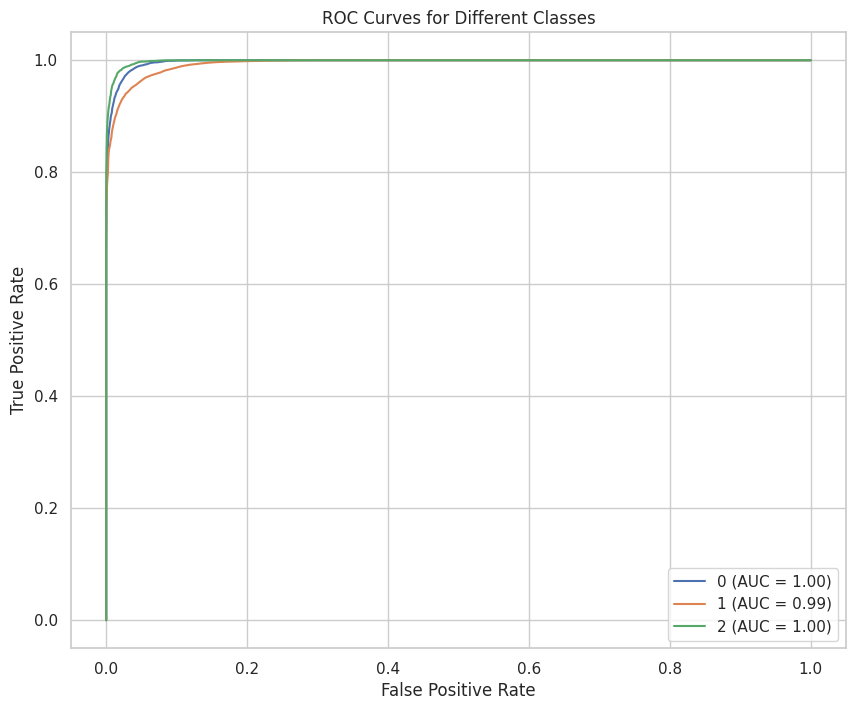

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = rf_classifier.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report for Random Forest Classifier:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Get predicted probabilities for each class
probas_ = rf_classifier.predict_proba(X_test)

# Initialize empty dictionaries to store ROC curve data and AUC scores
roc_curves = {}
auc_scores = {}

# Iterate over each class
for i in range(len(rf_classifier.classes_)):
    class_name = rf_classifier.classes_[i]
    fpr, tpr, thresholds = roc_curve((y_test == class_name).astype(int), probas_[:, i])
    roc_auc = auc(fpr, tpr)
    roc_curves[class_name] = (fpr, tpr)
    auc_scores[class_name] = roc_auc

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for class_name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc_scores[class_name]:.2f})')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classes')
plt.legend(loc='lower right')
plt.show()

## XG Boost Classifier

In [37]:
from xgboost import XGBClassifier

# Initialize and fit the XGBoost Classifier
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

# Predict on the test data
xgb_preds = xgb_classifier.predict(X_test)

# Generate a classification report
class_report_xgb = classification_report(y_test, xgb_preds)

# Display the classification report
print("Classification Report for XGBoost Classifier:")
print(class_report_xgb)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_preds)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report for XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6067
           1       0.97      0.98      0.98     13263
           2       0.98      0.97      0.98      6272

    accuracy                           0.97     25602
   macro avg       0.98      0.97      0.97     25602
weighted avg       0.97      0.97      0.97     25602

Confusion Matrix:
[[ 5840   227     0]
 [  139 13000   124]
 [    0   174  6098]]


**Cross validation score.**
What model we choose and why? Dive deep into the one of the models (XG Boost) and answer the research questions.
30% of the data